# 3D Pose Estimation Tutorial

## Acknowledgement

This tutorial is taken from the official OpenCV docs: [pose estimation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_pose/py_pose.html#pose-estimation)
and slightly modified.
Thank you to OpenCV team for the goodwork

## Learning Objective


The Goal for this tutorial is to help understand how to use `calib3d` module to create some 
3D effects in image. 
the problem now becomes how camera is placed in space to see our pattern image

**Note**: Not to be confused with pose estimation in [CMU Lab OpenPose](https://github.com/CMU-Perpetual-Computing-Labs/openpose)

### Packages

In [4]:
import os
import glob

import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Load Camera Calibration Results

This is going to be a small section. During the last session on camera calibration, you have found the camera matrix, distortion coefficients etc. Given a pattern image, we can utilize the above information to calculate its pose, or how the object is situated in space, like how it is rotated, how it is displaced etc. For a planar object, we can assume $Z=0$, such that, the problem now becomes how camera is placed in space to see our pattern image. So, if we know how the object lies in the space, we can draw some 2D diagrams in it to simulate the 3D effect. Let’s see how to do it.

Our problem is, we want to draw our 3D coordinate axis (X, Y, Z axes) on our chessboard’s first corner. X axis in blue color, Y axis in green color and Z axis in red color. So in-effect, Z axis should feel like it is perpendicular to our chessboard plane.

First, let’s load the camera matrix and distortion coefficients from the previous calibration result.
You're recommended to follow camera calibration tutorial first if the npz file below is not found in your folder

In [5]:
# load previous result from camera calibration
# you're recommended to follow camera_calibration tutorial first
with np.load("artifacts/calibresult.npz") as X:
    matrix, distortion, rvecs, tvecs = (X[var] for var in ("mtx", "distr", "rvecs", "tvecs"))

### Drawing Helper 

Now let’s create a function, draw which takes the corners in the chessboard (obtained using **cv2.findChessboardCorners())** and axis points to draw a 3D axis.

In [6]:
# define functions to draw 3D axis from given checkboard corners and axis points
def draw_3D_axis(img, origin, axispoints):
    """Draw 3D axis from given checkboard corners and axis points
    :param img (np array): image to be anotated with 3D drawing
    :param origin (np array): x,y position of the first corner
    :param projpoints (np array): projected 3D points to image plane
    """
    img = cv2.line(img, tuple(origin), tuple(axispoints[0].ravel()), (255,0,0), 5) # draw z axis line
    img = cv2.line(img, tuple(origin), tuple(axispoints[1].ravel()), (0,255,0), 5) # draw x axis line
    img = cv2.line(img, tuple(origin), tuple(axispoints[2].ravel()), (0,0,255), 5) # draw y axis line

    return img

In [7]:
def draw_3D_cube(img, origin, axispoints):
    """Draw 3D cube from given checkboard corners and axis points
    :param img (np array): image to be anotated with 3D drawing
    :param origin (np array): x,y position of the first corner
    :param projpoints (np array): projected 3D points to image plane
    """
    # axis from projpoints:
    # [[0,0,0], [0,3,0], [3,3,0], [3,0,0],
    #  [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]]
    axispoints = np.int32(axispoints).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [axispoints[:4]], -1, (0,255,0), -3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(axispoints[i]), tuple(axispoints[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [axispoints[4:]], -1, (0,0,255), 3)

    return img

## Setups

Then as in previous case, we create termination criteria, object points (3D points of corners in chessboard) and axis points. Axis points are points in 3D space for drawing the axis. We draw axis of length 3 (units will be in terms of chess square size since we calibrated based on that size). So our X axis is drawn from $(0,0,0)$ to $(3,0,0)$, so for Y axis. For Z axis, it is drawn from $(0,0,0)$ to $(0,0,-3)$. Negative denotes it is drawn towards the camera.

In [8]:
# termination criteria for corner subpixel 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [9]:
# object point 
objp = np.zeros((7*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

In [10]:
# we will draw axis of length 3 where units will be in terms of chess square size 
# since we calibrated based on that size. 
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
axisCube = np.float32(
    [[0,0,0], [0,3,0], [3,3,0], [3,0,0],
    [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]])

## Finding projection of 3D points in Image Plan

Now, as usual, we load each image. Search for 7x6 grid. If found, we refine it with subcorner pixels. Then to calculate the rotation and translation, we use the function, **cv2.solvePnPRansac()**. Once we those transformation matrices, we use them to project our axis points to the image plane. In simple words, we find the points on image plane corresponding to each of $(3,0,0),(0,3,0),(0,0,3)$ in 3D space. Once we get them, we draw lines from the first corner to each of these points using our draw() function. Done !!!

Loading images of checker board:

In [11]:
imagepaths = glob.glob("data/left*[0-9].jpg")  # checkboard image are left01.png, left02.png ... left11.png

Warning! Image not successful data/left11.jpg
Warning! Image not successful data/left09.jpg


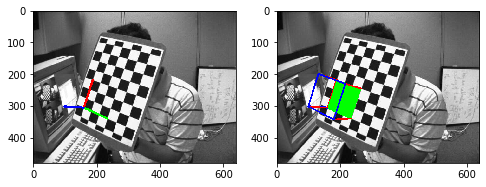

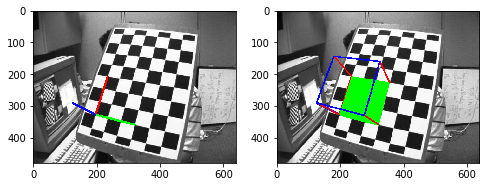

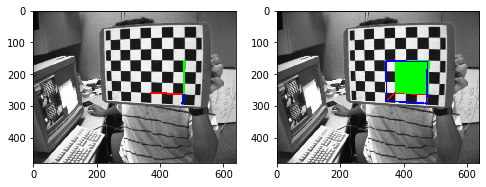

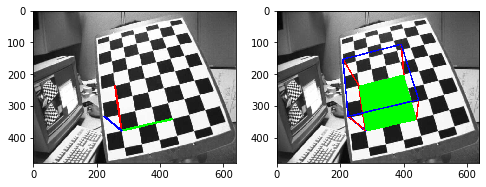

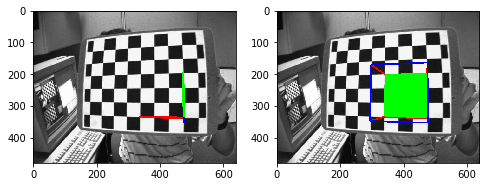

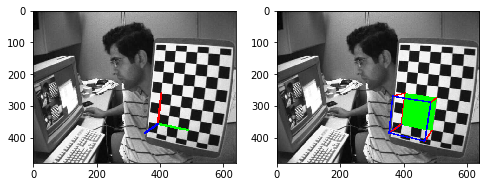

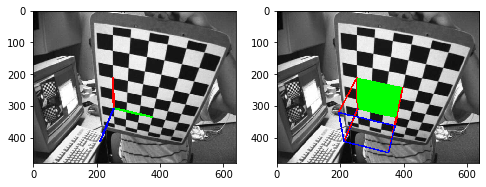

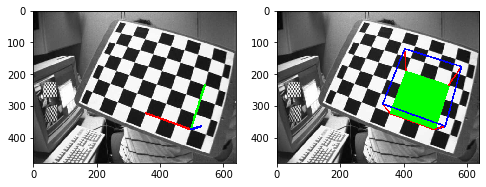

In [17]:
for fname in imagepaths:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    success, corners = cv2.findChessboardCorners(img, (7,6), cv2.CALIB_CB_ADAPTIVE_THRESH)

    if success == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, matrix, distortion)

        # project 3D points to image plane
        axispoints, jac = cv2.projectPoints(axis, rvecs, tvecs, matrix, distortion)

        # project 3D points to 8 corners in 3D space
        cubepoints, jac = cv2.projectPoints(axisCube, rvecs, tvecs, matrix, distortion)

        # prepare plot figure
        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)
        
        # draw axis of 3D projection in image
        origin = corners2[0].ravel()
        img1 = draw_3D_axis(img, origin, axispoints)
        ax1.imshow(img1)
        
        # draw 3D cubes in image
        img2 = draw_3D_cube(img, origin, cubepoints)
        ax2.imshow(img2)

    else:
        print("Warning! Image not successful %s" %fname)

cv2.destroyAllWindows()